In [2]:
import warnings
import math
import keras
import h5py
import scipy
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import src.preprocess
import src.cwt

%load_ext autoreload
%autoreload 2


In [3]:
# Get EGG Data
data = src.preprocess.PreProcess("eeg")
train, valid = data.train_valid.train_valid_split(0.3)
x_train, y_train = train.raw
x_valid, y_valid = valid.raw
x_test, y_test = data.test.raw

# Bring to 0
y_train -= 769
y_valid -= 769
y_test -= 769

print(x_train.shape)

(1480, 22, 1000)


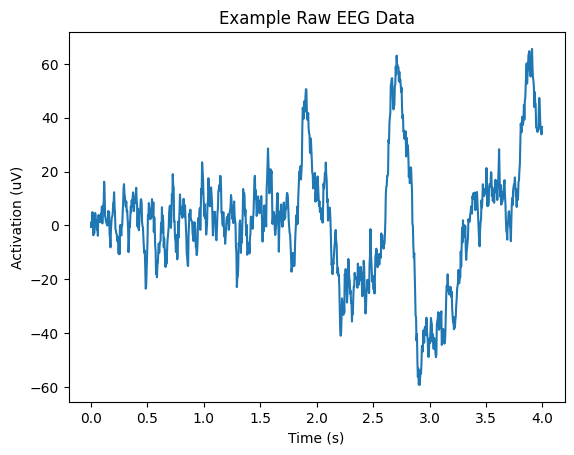

In [4]:
# Plot Example
t = np.arange(1000) / 250

plt.plot(t, x_train[0][0])
plt.ylabel("Activation (uV)")
plt.xlabel("Time (s)")
plt.title("Example Raw EEG Data")
plt.show()

In [5]:
def CAR(x: np.ndarray):
    """
    Common Average Referencing

    Removes common internal and external noises by subtracting the mean of all 22 electrodes from each electrode.
    """
    new_ref = np.mean(x, axis=1)
    return x - new_ref.reshape((new_ref.shape[0], 1, new_ref.shape[1]))

x_train = CAR(x_train)
x_valid = CAR(x_valid)
x_test = CAR(x_test)

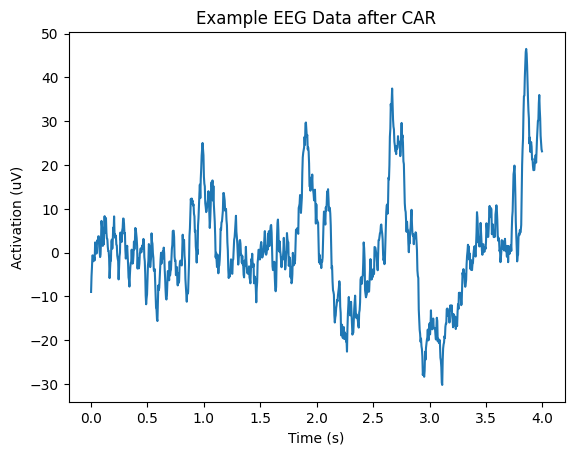

In [6]:
# Post CAR
t = np.arange(1000) / 250
plt.plot(t, x_train[0][0])
plt.ylabel("Activation (uV)")
plt.xlabel("Time (s)")
plt.title("Example EEG Data after CAR")
plt.show()

In [7]:
def erd_ers(x) -> np.ndarray:
    """
    Fifth-order zero-phase butter-worth filters isolates the Mu and Beta frequency bands.

    Mu: 8-14 Hz
    Beta: 15-30 Hz
    """
    num1, denom1 = scipy.signal.butter(5, [8, 30], btype='band', fs=250)
    
    ret = np.zeros_like(x)

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            ret[i][j] = scipy.signal.filtfilt(num1, denom1, x[i][j])
    return ret

x_train = erd_ers(x_train)
x_valid = erd_ers(x_valid)
x_test = erd_ers(x_test)

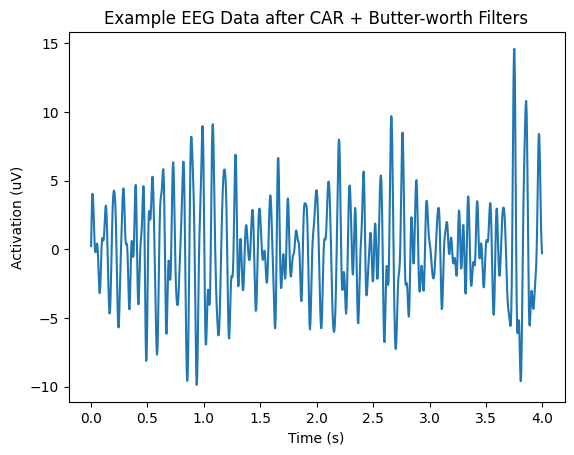

In [8]:
# Post Filter
t = np.arange(1000) / 250
plt.plot(t, x_train[0][0])
plt.ylabel("Activation (uV)")
plt.xlabel("Time (s)")
plt.title("Example EEG Data after CAR + Butter-worth Filters")
plt.show()

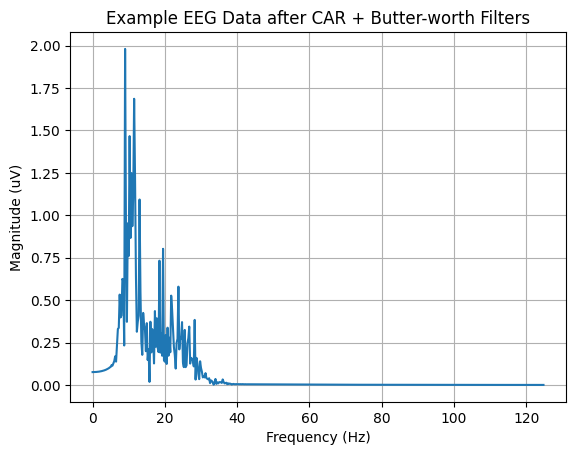

In [9]:
# sample spacing
T = 1.0 / 250
yf = scipy.fft.fft(x_train[0][0])
xf = scipy.fft.fftfreq(1000, 1/250)[:1000//2]

plt.plot(xf, 2.0/1000 * np.abs(yf[0:1000//2]))
plt.grid()
plt.ylabel("Magnitude (uV)")
plt.xlabel("Frequency (Hz)")
plt.title("Example EEG Data after CAR + Butter-worth Filters")
plt.show()

In [10]:
def get_windows(x: np.ndarray, w = 5) -> np.ndarray:
    """
    Extracts 0.8 second windows and stacks them
    """
    t_prime = int(x.shape[2] / w)
    return np.vstack([x[:,:,i*t_prime:(i+1)*t_prime] for i in range(w)])

x_train_windows = get_windows(x_train)
x_valid_windows = get_windows(x_valid)
x_test_windows = get_windows(x_test)

# There amount of data multiplies by 5
y_train_windows = np.tile(y_train, 5)
y_valid_windows = np.tile(y_valid, 5)
y_test_windows = np.tile(y_test, 5)

print(x_train_windows.shape, y_train_windows.shape)

(7400, 22, 200) (7400,)


In [11]:
# Create an example CWT
test_cwt = src.cwt.CWT(x_train_windows[:5])

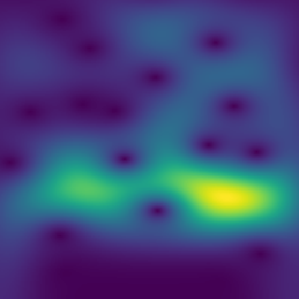

In [12]:
test_cwt.get_png(0, 0, 299, 299)

In [13]:
def minibatch_c(x, f: h5py.File, dbname: str, batch_size=64):
    """
    Fills a h5py dataset in the open file with the CWT images from x.

    x - eeg signal data (modify before inputting) \n
    f - open h5py.File 
    """
    shape = (x.shape[0], 299, 299, 3)
    db = f.create_dataset(dbname, shape = shape, dtype=np.dtype('B'))
    for i in tqdm.trange((math.ceil(x.shape[0] / batch_size)), desc="Filling {}".format(dbname), colour='green'):
        with warnings.catch_warnings(action="ignore"):
            cwt = src.cwt.CWT(x[i*batch_size:(i+1)*batch_size], freqs = np.linspace(2.8, 30, 200))
        cwt.fill_db(db, i*batch_size)

In [14]:
def create_x_h5(x_train, x_valid, x_test, channels):
    for c in channels:
        f = h5py.File('inceptionv3_c{}.h5'.format(c), 'w-')
        minibatch_c(x_train[:,c:c+1], f, 'x_train')
        minibatch_c(x_valid[:,c:c+1], f, 'x_valid')
        minibatch_c(x_test[:,c:c+1], f, 'x_test')
        f.close()

def create_y_h5(y_train, y_valid, y_test):
    f = h5py.File('inceptionv3_y.h5', 'w-')
    f.create_dataset('y_train', data=y_train, dtype=np.dtype('B'))
    f.create_dataset('y_valid', data=y_valid, dtype=np.dtype('B'))
    f.create_dataset('y_test', data=y_test, dtype=np.dtype('B'))
    f.close()

In [15]:
#create_y_h5(y_train_windows, y_valid_windows, y_test_windows)

#create_x_h5(x_train=x_train_windows, 
#            x_valid=x_valid_windows, 
#            x_test=x_test_windows,
#            channels=[2])

In [16]:
with h5py.File('inceptionv3_c2.h5', 'r') as f:
    print(f['x_train'])
    print(f['x_valid'])
    print(f['x_test'])

    display(PIL.Image.fromarray(f['x_train'][99]))
    display(PIL.Image.fromarray(f['x_valid'][99]))
    display(PIL.Image.fromarray(f['x_test'][99]))

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'inceptionv3_c2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)